In [2]:
import import_data
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from operator import itemgetter
import community

In [3]:
# Import businesses
businesses = import_data.import_businesses()

In [4]:
# Prepare data
busicat = businesses['categories']

In [5]:
# Find unique categories
# all categories are lists, simply put them all together
l = []
for entry in busicat:
    l += entry

# drop duplicates by converting to set
cats = set(l)

In [6]:
# Convert category entries to columns
data = busicat.apply(lambda x: pd.Series(1, index=x))

# Create list of data series
mapdata = {}
for cat in cats:
    mapdata[cat] = (data[data[cat]==1].count())


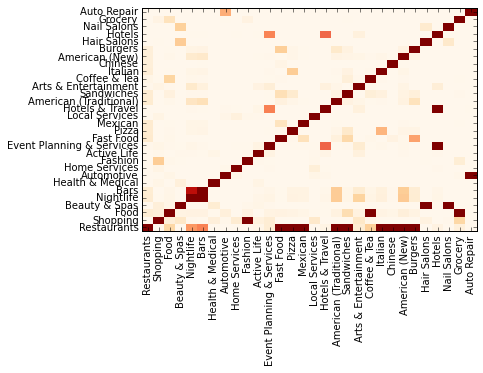

In [7]:
# Plot a few of the most used categories and show incoming/outgoing

# Normalizing to show only relative values
normaldata = {}
for item in mapdata:
    normaldata[item] = mapdata[item]/mapdata[item].max()

norm_map = pd.DataFrame(normaldata)

#Get only 30
sel = data.count().order(ascending=False)[0:30].index

df = norm_map.loc[sel][sel]

plt.pcolor(df, cmap='OrRd')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation='vertical')
plt.show()

In [8]:
# Modify data to create adjacency matrix: set all values above 1 to 1 and set diagonal to 0
df = pd.DataFrame(mapdata)
#map[newmap>1]=1
np.fill_diagonal(df.values, 0)

#Make undirected by summing both directions together
#undirected = newmap.values + newmap.values.transpose()

In [9]:
# Make graph from adjacency matrix
graph = nx.from_numpy_matrix(df.values)

# Relable nodes
mapping = dict(zip(range(len(cats)),sorted(list(cats))))

nx.relabel_nodes(graph, mapping, False)

nx.write_gml(graph,"test.gml")

In [10]:
#Graph fun!
#G = graph.copy()
#for u,v,d in G.edges(data=True):
#    d['weight'] = 1/d['weight']
#nx.shortest_path(G)

In [11]:
# Get Partitions with Louvain method
part = community.best_partition(graph)
mod = community.modularity(part, graph)
print("Modularity: %f" % mod)

Modularity: 0.644992


In [17]:
# Structure them for info purpose
parts_with_weights = {}
parts = {}
for item in part:
    n = part[item]  # Partition number
    if n not in parts_with_weights: #Check if list for partition exists
        parts_with_weights[n] = []
    if n not in parts: #Check if list for partition exists
        parts[n] = []
    
    #add node with degree in graph (for sorting) as tuples to list
    parts_with_weights[n].append((item, graph.degree()[item]))
    parts[n].append(item)
    
# Sort like you have never sorted before
for item in parts_with_weights:
    parts_with_weights[item] = sorted(parts_with_weights[item], key=itemgetter(1), reverse=True)
    
#Take first item as names (and only first part of tuple)
supercats = {key:parts_with_weights[key][0][0] for key in parts_with_weights}

In [18]:
print(supercats)

{0: 'Event Planning & Services', 1: 'Restaurants', 2: 'Food', 3: 'Local Services', 4: 'Health & Medical', 5: 'Shopping', 6: 'Active Life', 7: 'Pets', 8: 'Automotive'}


In [ ]:
#Most convoluted function ever:
#Make a list for every key in allparts (every supercategory)
#Then turn list of tuples into list to get only names
#Use that as an index for data
#sum along row to get the number to see how many categories beloning to the supercat are in there
supercatframe = pd.DataFrame([data[[item[0] for item in allparts[key]]].sum(axis=1) for key in allparts])

#Just use argmax to determine supercat for business: TODO: Better way?
catmap = supercatframe.idxmax()

#Special case: No category at all will be -1
catmap = catmap.fillna(-1)

#Add supercat to dataframe
businesses['super category'] = catmap

In [ ]:
# Create The mighty KML!
#Little helper function to restrict to one city because google earth is helpless otherwise
def get_by_city(city):
    return businesses[businesses['city']==city]

#second helper for color conv, copies from activestate.com and slightly modfied
def format_color(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBBff """
    rgb_tuple = (rgb_tuple[0]*255, rgb_tuple[1]*255, rgb_tuple[2]*255)
    hexcolor = '%02x%02x%02x' % rgb_tuple
    return hexcolor

In [ ]:
from simplekml import Kml, Style
from colorsys import hsv_to_rgb as color

kml = Kml()

#Create folder for businesses
fol = kml.newfolder(name="Businesses")

#Create subfolder for every category and save them in dictionary
subfolders = {key: fol.newfolder(name=supercats[key]) for key in supercats}


#Create color for every category and also save them in dict
styles = {key: Style() for key in supercats}
for key in supercats:
    styles[key].labelstyle.scale = 0
    styles[key].iconstyle.icon.href = 'http://thydzik.com/thydzikGoogleMap/markerlink.php?color=%s' % format_color(color(key/len(supercats), 1, 1))


#Special case for uncategories (those are -1 and will be black)
subfolders[-1] = fol.newfolder(name='Uncategorized')
styles[-1] = Style()
styles[-1].labelstyle.scale = 0
styles[-1].iconstyle.icon.href = 'http://thydzik.com/thydzikGoogleMap/markerlink.php?color=000000'

In [ ]:
for item in get_by_city('Las Vegas')[['name', 'longitude', 'latitude','super category']].values:
    pnt = subfolders[item[3]].newpoint(name=item[0], coords=[(item[1],item[2])])
    pnt.style = styles[item[3]]

kml.save("busi.kml")

In [13]:
sub = graph.subgraph(parts[5])
# Get Partitions with Louvain method
subpart = community.best_partition(sub)
submod = community.modularity(part, sub)
print("Modularity: %f" % mod)

Modularity: 0.644992


In [14]:
subparts = {}
for item in part:
    n = part[item]  # Partition number
    if n not in subparts: #Check if list for partition exists
        subparts[n] = []
        
    subparts[n].append(item)

In [21]:
subparts[0]
main = {key: subparts[key][0][0] for key in subparts}
print(main)

{0: 'C', 1: 'T', 2: 'B', 3: 'I', 4: 'A', 5: 'F', 6: 'F', 7: 'P', 8: 'A'}


In [ ]:
supercatframe

In [22]:
supercats

{0: 'Event Planning & Services',
 1: 'Restaurants',
 2: 'Food',
 3: 'Local Services',
 4: 'Health & Medical',
 5: 'Shopping',
 6: 'Active Life',
 7: 'Pets',
 8: 'Automotive'}